In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [119]:
inf_rate_df = pd.read_csv('./data/inflation rate ph.csv')
int_rate_df = pd.read_csv('./data/monetaryDeicisionProcessed.csv')

snp_500_df = pd.read_csv('./data/S&P 500 Historical Data.csv')
psei_df = pd.read_csv('./data/PSEi Composite Historical Data.csv')

usd_php_df = pd.read_csv('./data/USD_PHP Historical Data.csv')

Some questions we want to try to answer:
1. Inflation rate is bad especially for consumers, we want to know:
    1. does USD/PHP exchange rate affect this number? and how fast?
    2. how strong does inflation rate impract interest rate decisions?
2. Using PSEI to represent philippine economy, 
    1. how does interest rate affect this?
    2. business sometimes use USD, is there correlation with exchange rate
3. How do the S&P 500 and PSEI influence the exchange rate (USD/PHP)?

### Data processing


In [120]:
inf_rate_df['Date'] = pd.to_datetime(inf_rate_df['Year'].astype(str) + '-' + inf_rate_df['Month'].astype(str) + '-01',
            format='%Y-%m-%d')
inf_rate_df.drop(columns=['Year', 'Month'], inplace=True)

In [121]:
int_rate_df['Date'] = pd.to_datetime(int_rate_df['Date'])

In [122]:
snp_500_df['Date'] = pd.to_datetime(snp_500_df['Date'])
snp_500_df['Price'] = snp_500_df['Price'].str.replace(',','').astype(float)
snp_500_df['Change %'] = snp_500_df['Change %'].str.replace('%','').astype(float)
# snp_500_df.drop(columns=['Vol.'], inplace=True)

In [123]:
psei_df['Date'] = pd.to_datetime(psei_df['Date'])
psei_df['Price'] = psei_df['Price'] .str.replace(',','').astype(float)
psei_df['Change %']  = psei_df['Change %'].str.replace('%','').astype(float)

In [124]:
usd_php_df['Date'] = pd.to_datetime(usd_php_df['Date'])
usd_php_df['Change %']  = usd_php_df['Change %'].str.replace('%','').astype(float)

### Feature selection

In [125]:
scaler = MinMaxScaler()

In [126]:
inf_rate_df['normalized_inflation'] = scaler.fit_transform(inf_rate_df[['Inflation Rate YoY']])
int_rate_df['normalized_TRRR'] = scaler.fit_transform(int_rate_df[['TRRR']])
snp_500_df['normalized_price'] = scaler.fit_transform(snp_500_df[['Price']])
psei_df['normalized_price'] = scaler.fit_transform(psei_df[['Price']])
usd_php_df['normalized_price'] = scaler.fit_transform(usd_php_df[['Price']])

In [127]:
temp1 = snp_500_df[['Date','Price', 'normalized_price']].resample('M', on='Date').mean().reset_index()
temp1 = temp1.rename(columns={'Price': 'SNP500_Price', 'normalized_price': 'SNP500_Normalized'})

temp2 = psei_df[['Date','Price', 'normalized_price']].resample('M', on='Date').mean().reset_index()
temp2 = temp2.rename(columns={'Price': 'PSEI_Price', 'normalized_price': 'PSEI_Normalized'})

temp3 = usd_php_df[['Date','Price', 'normalized_price']].resample('M', on='Date').mean().reset_index()
temp3 = temp3.rename(columns={'Price': 'USD_PHP_Price', 'normalized_price': 'USD_PHP_Normalized'})

# monthly average price
merged_df = temp1.merge(temp2, on='Date').merge(temp3, on='Date')

In [128]:
temp1 = int_rate_df.resample('M', on='Date').mean().reset_index().ffill()
int_rate_df

merged_df = merged_df.merge(temp1[['Date', 'normalized_TRRR']], on='Date')

# already monthly data
temp2 = inf_rate_df.resample('M', on='Date').mean().reset_index()
merged_df = merged_df.merge(temp2[['Date', 'normalized_inflation']], on='Date')
merged_df['Date'] = merged_df['Date'].dt.strftime("%Y-%m")
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format="%Y-%m")

summary: 
```
inf_rate_df
int_rate_df
snp_500_df
psei_df
usd_php_df

merged_df
```

### Analysis

In [130]:
merged_df.columns

Index(['Date', 'SNP500_Price', 'SNP500_Normalized', 'PSEI_Price',
       'PSEI_Normalized', 'USD_PHP_Price', 'USD_PHP_Normalized',
       'normalized_TRRR', 'normalized_inflation'],
      dtype='object')

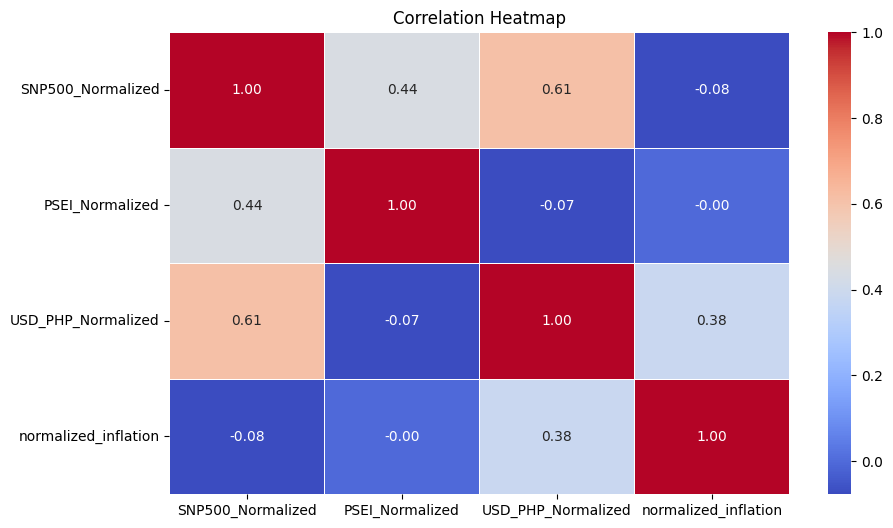

In [ ]:
# Compute correlation matrix
corr_matrix = merged_df[['SNP500_Normalized', 'PSEI_Normalized', 'USD_PHP_Normalized', 'normalized_inflation']].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Titles and labels
plt.title("Correlation Heatmap")
plt.show()


### Judging by the Image Above (from Highest to Lowest)

**0.61** - S&P 500 | Exchange Rate  
There is a moderate positive correlation between the US economy and the exchange rate. As stock prices increase, the PHP tends to depreciate.

**0.39** - Exchange Rate | Inflation  
A weak correlation, which can mean two things:  
1. When the exchange rate increases, imported goods become more expensive.  
2. Due to inflation, the PHP depreciates faster than the USD.

**0.37** - PSEI | S&P 500  
A weak correlation, meaning the Philippine stock market is somewhat influenced by the US stock market but not strongly.

**-0.10** - PSEI | Exchange Rate  
Although close to 0, this confirms the suspected direction of influence.


---

We want to focus first on the 0.39, we want to confirm which comes first. We want to answer our first question


### 1A. does USD/PHP exchange rate affect inflation number? and how fast?

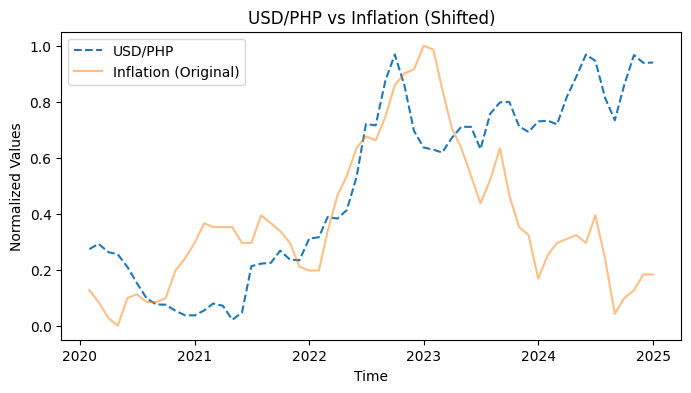

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(merged_df['Date'], merged_df['USD_PHP_Normalized'], label="USD/PHP", linestyle='dashed')
plt.plot(merged_df['Date'], merged_df['normalized_inflation'], label="Inflation (Original)", alpha=0.5)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Normalized Values")
plt.title("USD/PHP vs Inflation")
plt.show()

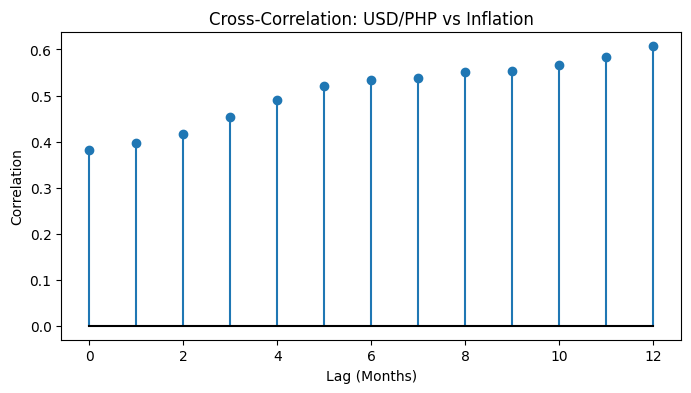

In [ ]:
lags = np.arange(0, 13)

ccf_values = sm.tsa.stattools.ccf(merged_df['USD_PHP_Normalized'], merged_df['normalized_inflation'], nlags=lags[-1]+1)

plt.figure(figsize=(8, 4))
plt.stem(lags, ccf_values, basefmt="black") 
plt.xlabel("Lag (Months)")
plt.ylabel("Correlation")
plt.title("Cross-Correlation: USD/PHP vs Inflation")
plt.show()


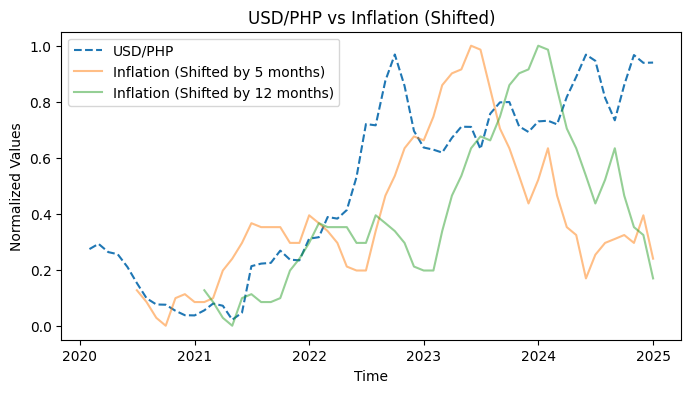

0.5089468041902109


In [134]:

plt.figure(figsize=(8, 4))
plt.plot(merged_df['Date'], merged_df['USD_PHP_Normalized'], label="USD/PHP", linestyle='dashed')

plt.plot(merged_df['Date'], merged_df['normalized_inflation'].shift(5), label=f"Inflation (Shifted by {5} months)", alpha=0.5)
plt.plot(merged_df['Date'], merged_df['normalized_inflation'].shift(12), label=f"Inflation (Shifted by {12} months)", alpha=0.5)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Normalized Values")
plt.title("USD/PHP vs Inflation (Shifted)")
plt.show()
print(merged_df['USD_PHP_Normalized'].corr(merged_df['normalized_inflation'].shift(5)))

Given our limited dataset (60 months), we should limit the lag range to avoid drawing conclusions from too little data (ensuring that each month's contribution isn’t overly exaggerated).

### Conclusion:
- I chose lag of 5 months because it is where the ccf slows down and we do not want to sacrifice more data. We get a correlation score or 0.5089 (moderate positive) 
- This suggests that USD PHP exchange rate influence inflation after 5 months or more. We would need more data points to be able to confirm this

---

### 1B. how strong does inflation rate impract interest rate decisions?

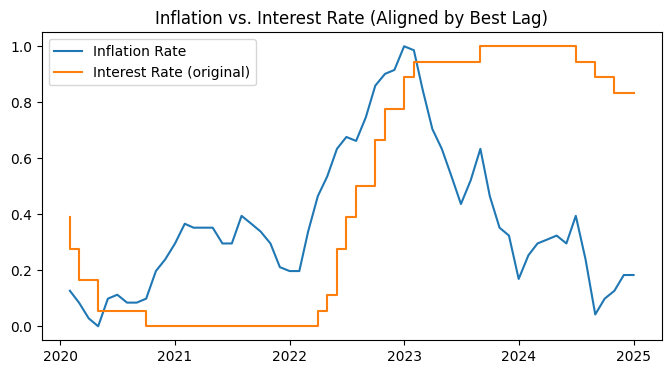

In [135]:
plt.figure(figsize=(8, 4))
plt.plot(merged_df['Date'], merged_df['normalized_inflation'], label="Inflation Rate")

plt.step(merged_df['Date'], merged_df['normalized_TRRR'], label=f"Interest Rate (original)")


plt.legend()
plt.title("Inflation vs. Interest Rate (Aligned by Best Lag)")
plt.show()

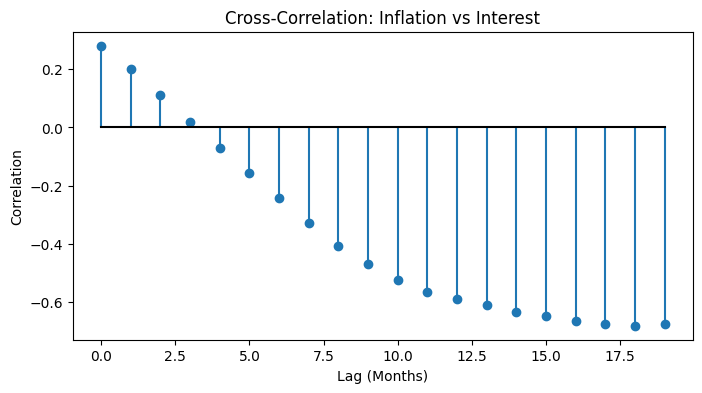

In [136]:
lags = np.arange(0, 20)

ccf_values = sm.tsa.stattools.ccf(merged_df['normalized_inflation'], merged_df['normalized_TRRR'], nlags=lags[-1]+1)

plt.figure(figsize=(8, 4))
plt.stem(lags, ccf_values, basefmt="black") 
plt.xlabel("Lag (Months)")
plt.ylabel("Correlation")
plt.title("Cross-Correlation: Inflation vs Interest")
plt.show()

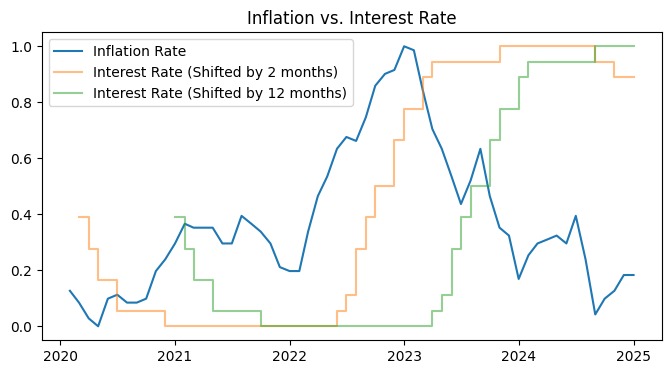

In [137]:
plt.figure(figsize=(8, 4))
plt.plot(merged_df['Date'], merged_df['normalized_inflation'], label="Inflation Rate")

shift = 2
plt.step(merged_df['Date'], merged_df['normalized_TRRR'].shift(shift), label=f"Interest Rate (Shifted by {shift} months)", alpha=0.5)

shift = 12
plt.step(merged_df['Date'], merged_df['normalized_TRRR'].shift(shift), label=f"Interest Rate (Shifted by {shift} months)", alpha=0.5 )

plt.legend()
plt.title("Inflation vs. Interest Rate")
plt.show()

In [138]:
merged_df['normalized_inflation'].corr(merged_df['normalized_TRRR'].shift(shift))

-0.5834265888876943

The result doesn't look very promising, this implies that increase in inflation will decrease interest rates after 12 months. What about we try the opposite

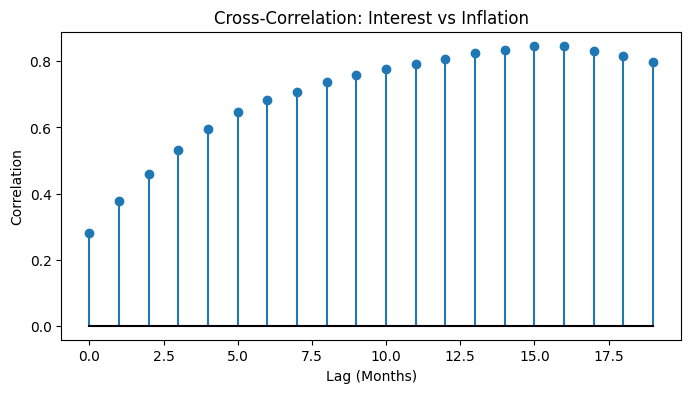

In [139]:
lags = np.arange(0, 20)

ccf_values = sm.tsa.stattools.ccf(merged_df['normalized_TRRR'], merged_df['normalized_inflation'], nlags=lags[-1]+1)

plt.figure(figsize=(8, 4))
plt.stem(lags, ccf_values, basefmt="black") 
plt.xlabel("Lag (Months)")
plt.ylabel("Correlation")
plt.title("Cross-Correlation: Interest vs Inflation")
plt.show()

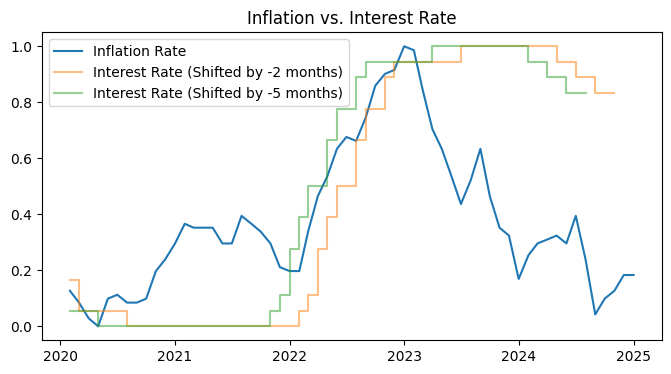

In [140]:
plt.figure(figsize=(8, 4))
plt.plot(merged_df['Date'], merged_df['normalized_inflation'], label="Inflation Rate")

shift = -2
plt.step(merged_df['Date'], merged_df['normalized_TRRR'].shift(shift), label=f"Interest Rate (Shifted by {shift} months)", alpha=0.5)

shift = -5
plt.step(merged_df['Date'], merged_df['normalized_TRRR'].shift(shift), label=f"Interest Rate (Shifted by {shift} months)", alpha=0.5 )

plt.legend()
plt.title("Inflation vs. Interest Rate")
plt.show()

In [141]:
merged_df['normalized_inflation'].corr(merged_df['normalized_TRRR'])

0.2808541080934447

In [142]:
merged_df['normalized_inflation'].corr(merged_df['normalized_TRRR'].shift(-5))

0.6297655302204004

We expect that when inflation rises, interest rates should also increase. However, our results for the lagging interest rate (inflation leading interest rates) show a negative correlation of -0.58 at lag 12, suggesting that higher inflation is associated with lower interest rates after a year. This contradicts the conventional economic expectations.

When we reverse the relationship and analyze lagging inflation (interest rates leading inflation), we observe a strong positive correlation of 0.63 at lag 5. This suggests that interest rate changes influence inflation after 5 months.

Testing the correlation between inflation and interest rates in the same month is relatively low (0.28), implying that immediate responses between these two variables are weak.

In summary, I think that interest rates affect inflation more than inflation is affecting interests rates. To truly understand the situation we need to study more about the factors that affects inflation to causes this reaction. Alternatively we should also look into the basis of BSP's decision for change in interest.

---

### 2A. Using PSEI to represent philippine economy, how does interest rate affect this?

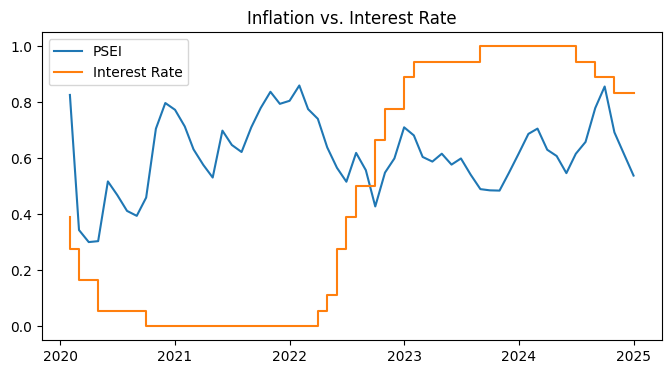

In [149]:
plt.figure(figsize=(8, 4))
plt.plot(merged_df['Date'], merged_df['PSEI_Normalized'], label="PSEI")

plt.step(merged_df['Date'], merged_df['normalized_TRRR'], label=f"Interest Rate")

plt.legend()
plt.title("Inflation vs. Interest Rate")
plt.show()

They do not seem to be very well correlated

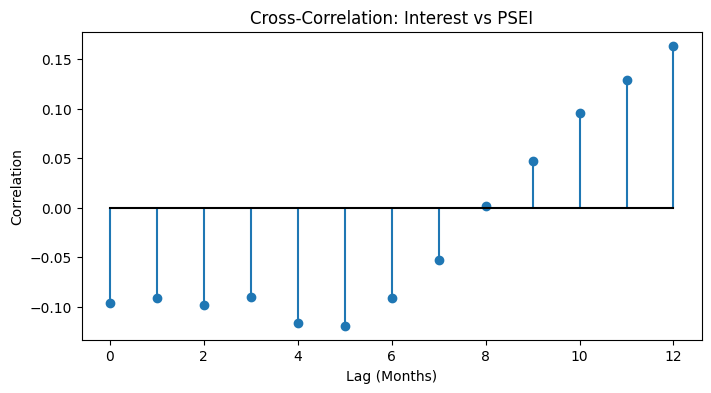

In [152]:
lags = np.arange(0, 13)

ccf_values = sm.tsa.stattools.ccf(merged_df['normalized_TRRR'], merged_df['PSEI_Normalized'], nlags=lags[-1]+1)

plt.figure(figsize=(8, 4))
plt.stem(lags, ccf_values, basefmt="black") 
plt.xlabel("Lag (Months)")
plt.ylabel("Correlation")
plt.title("Cross-Correlation: Interest vs PSEI")
plt.show()

There is likely no immediate effect, interest rates also do not change as often as PSEI. A better indicator for comparison would be gdp. 

---

### 2B. some business use USD, is there correlation with exchange rate

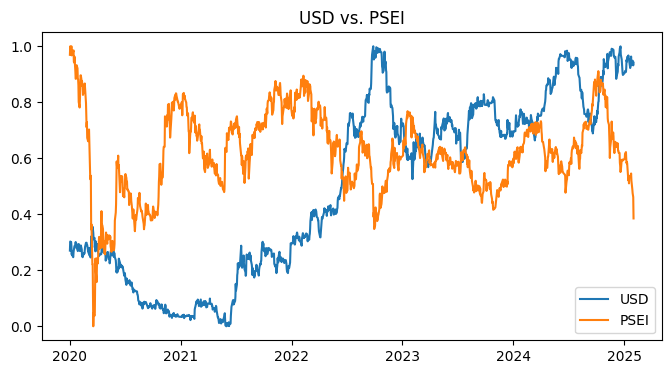

In [161]:
psei_usd_merge = psei_df.merge(usd_php_df, on='Date')
psei_usd_merge = psei_usd_merge.rename(columns={
    'normalized_price_x':'normalized_PSEI',
    'normalized_price_y':'normalized_USD',
})
plt.figure(figsize=(8, 4))

plt.plot(psei_usd_merge['Date'], psei_usd_merge['normalized_USD'], label = "USD")
plt.plot(psei_usd_merge['Date'], psei_usd_merge['normalized_PSEI'], label="PSEI")



plt.legend()
plt.title("USD vs. PSEI")
plt.show()

If USD affects psei we should we slight negative correlation in future

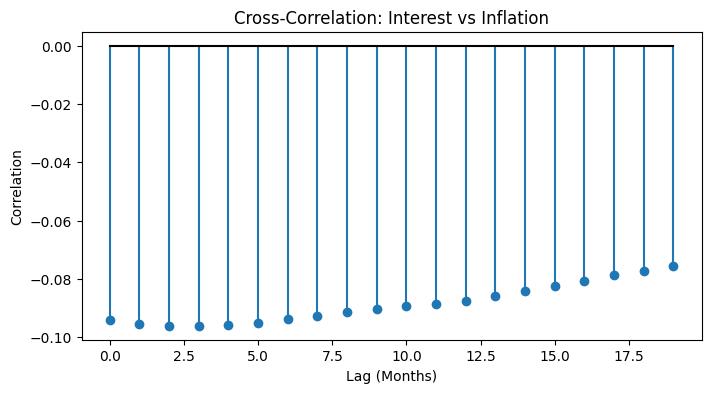

In [163]:
lags = np.arange(0, 20)
ccf_values = sm.tsa.stattools.ccf(psei_usd_merge['normalized_USD'], psei_usd_merge['normalized_PSEI'], nlags=lags[-1]+1)

plt.figure(figsize=(8, 4))
plt.stem(lags, ccf_values, basefmt="black") 
plt.xlabel("Lag (Months)")
plt.ylabel("Correlation")
plt.title("Cross-Correlation: Interest vs Inflation")
plt.show()

The data shows minimal correlation between USD/PHP exchange rates and the PSEI, suggesting that any impact is short-term and not very significant. This could indicate one of three possibilities:

1. There is a change and this -0.1 correlation is the change to the market.
2. Only a small portion of the PSEI market is directly affected by USD fluctuations, limiting its overall impact.
3. It is irrelavant considering it's low score.

---

### 3. How do the S&P 500 and PSEI influence the exchange rate (USD/PHP)?

In [ ]:
q3_merged = psei_df.merge(snp_500_df, on='Date').merge(usd_php_df, on='Date')
q3_merged = q3_merged.rename(columns={
    'normalized_price_x':'PSEI',
    'normalized_price_y': 'snp500',
    'normalized_price':'exchange'
})
q3_merged['const'] = 1
X = q3_merged[['const', 'PSEI', 'snp500']]
y = q3_merged['exchange']


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

Best Alpha: 2.1544346900318843
Ridge Coefficients: [ 0.         -0.11368423  0.23129448]


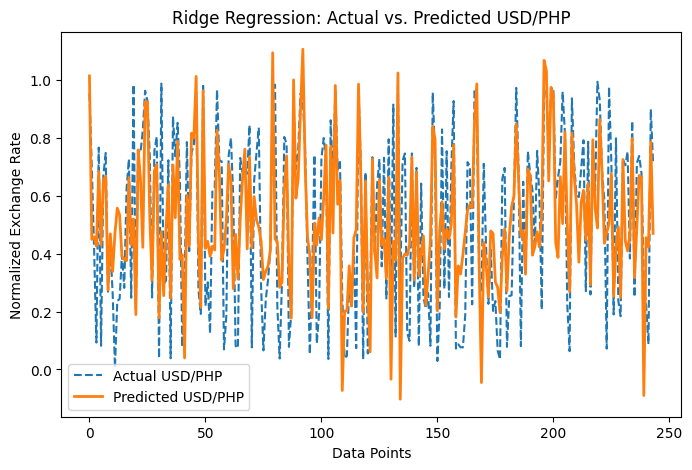

In [ ]:
alphas = np.logspace(-3, 3, 100)  
ridge = RidgeCV(alphas=alphas, store_cv_values=True)
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

print(f"Best Alpha: {ridge.alpha_}")
print(f"Ridge Coefficients: {ridge.coef_}")

plt.figure(figsize=(8, 5))
plt.plot(y_test.values, label="Actual USD/PHP", linestyle='dashed')
plt.plot(y_pred, label="Predicted USD/PHP", linewidth=2)
plt.xlabel("Data Points")
plt.ylabel("Normalized Exchange Rate")
plt.title("Ridge Regression: Actual vs. Predicted USD/PHP")
plt.legend()
plt.show()


In [ ]:

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


R² Score: 0.5363
RMSE: 0.2093
MAE: 0.1663


Summary of Findings:
- Model Fit: R² = 0.5363 (explains ~53.6% of exchange rate variance)
- PSEI Impact: -0.1137 | As PSEI rises, PHP strengthens (USD/PHP decreases)
- S&P 500 Impact: 0.2313 | As S&P 500 rises, PHP weakens (USD/PHP increases)

Interpretation:
- Whenever PSEI goes up, this means exchange rate goes down (as expected)
- Opposite also happens where snp500 goes well, exchange rate follows
- S&P500 also has twice more impact than PSEI to prediction
- Using these 2 variables as prediction to the exchange rate, it can only explain 53% of the variance to us, making it a not so good predictor 